# Human PBMCs from Sun et al.

Here we analyse sample 1_CS PBMCs from a healthy donor published by [Sun et al.](https://www.nature.com/articles/s41467-019-09639-3)
Link to the dataset: [GSM3665016](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=gsm3665016)

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.4+6.ge614f59 anndata==0.6.22.post1 umap==0.3.9 numpy==1.15.4 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
# install some R packages through rpy2 (the rest are installed via conda)
packnames = ('RColorBrewer', 'gam', 'ggplot2', 'plyr')
from rpy2.robjects.vectors import StrVector
#utils.install_packages(StrVector(packnames))
results_file = './write/Sun1_pbmcs.h5ad'  # the file that will store the analysis results

In [4]:
%%R
# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
#library(slingshot)
#library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)

In [6]:
## Load previously processed dataset
#adata = sc.read_h5ad(results_file)

In [9]:
# Set up data loading
file_base = '../../../Munich/datasets/human/Sun_PBMC/sample1_CS/GSM3665016_CS_PBL_'
data_file_end = 'matrix.mtx.gz'
barcode_file_end = 'barcodes.tsv.gz'
gene_file_end = 'genes.tsv.gz'

In [18]:
# Data set load & annotation
#Parse Filenames
data_file = file_base+data_file_end
barcode_file = file_base+barcode_file_end
gene_file = file_base+gene_file_end

#Load data
adata = sc.read(data_file, cache=True)
adata = adata.transpose()
adata.X = adata.X.toarray()

barcodes = pd.read_csv(barcode_file, header=None, sep='\t')
genes = pd.read_csv(gene_file, header=None, sep='\t')

#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata.obs = barcodes

genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adata.var = genes

... reading from cache file cache/..-..-..-Munich-datasets-human-Sun_PBMC-sample1_CS-GSM3665016_CS_PBL_matrix.h5ad


In [19]:
adata

AnnData object with n_obs × n_vars = 1768 × 32738 
    var: 'gene_id'

In [20]:
adata.var.head()

gene_id
gene_symbol                  
MIR1302-10    ENSG00000243485
FAM138A       ENSG00000237613
OR4F5         ENSG00000186092
RP11-34P13.7  ENSG00000238009
RP11-34P13.8  ENSG00000239945

In [21]:
adata.var_names_make_unique()

In [22]:
# Checking the total size of the data set
adata.shape

(1768, 32738)

# 1. Pre-processing and visualization

## 1.1 Quality control

In [23]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

In [24]:
mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']


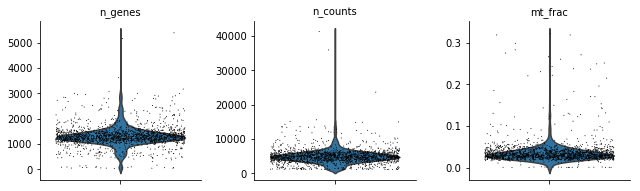

In [25]:
# Quality control - plot QC metrics
sc.pl.violin(adata, ['n_genes', 'n_counts', 'mt_frac'],
             jitter=0.4, multi_panel=True)

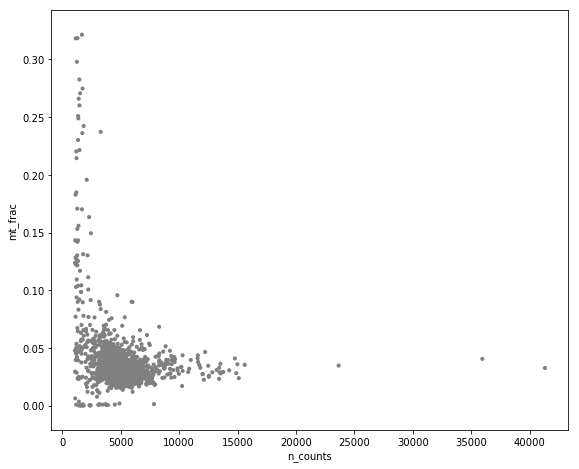

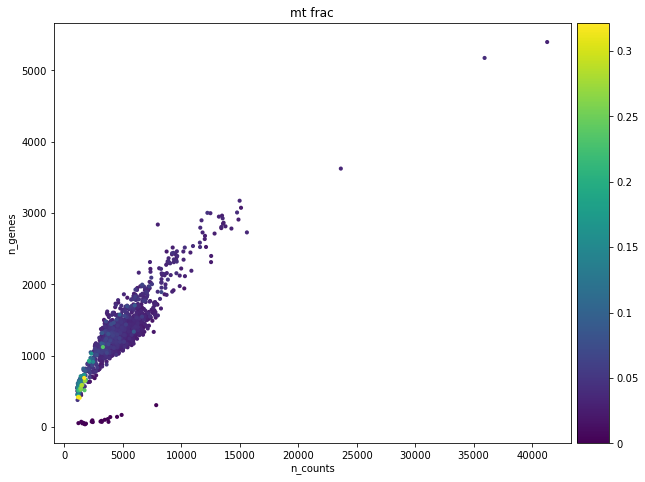

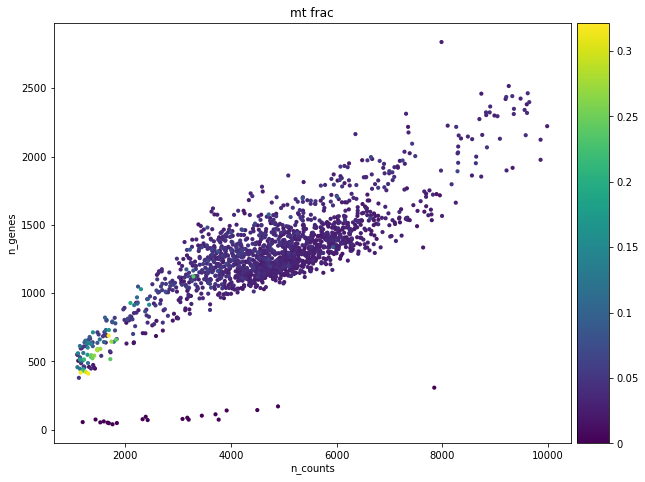

In [26]:
sc.pl.scatter(adata, x='n_counts', y='mt_frac')
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='mt_frac')
sc.pl.scatter(adata[adata.obs['n_counts'] < 10000], x='n_counts', y='n_genes', color='mt_frac')

There are a bunch of cells separating from the rest, with low number of genes and relatively high counts. We want to exclude them. Also, we exclude a couple of cells with very high n_genes and n_count, which could be doublets.

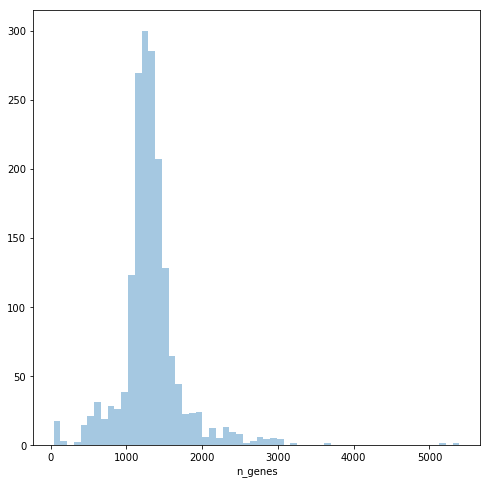

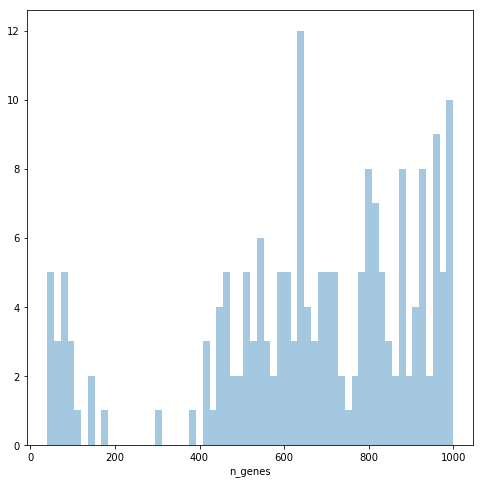

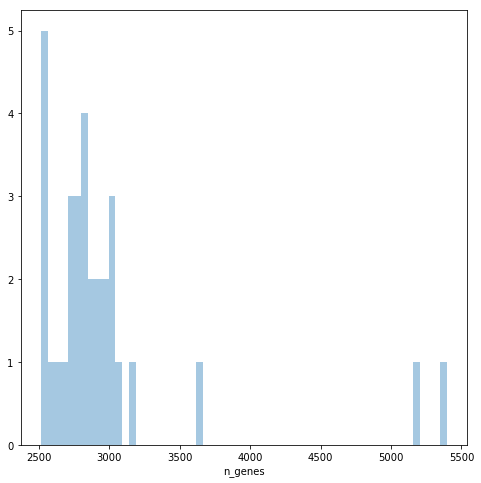

In [28]:
#Thresholding decision: genes
p1 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p2 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=60)
plt.show()

p3 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']>2500], kde=False, bins=60)
plt.show()


In [29]:
# Thresholding on number of genes
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 400)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, max_genes = 3500)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 1768
filtered out 22 cells that haveless than 400 genes expressed
Number of cells after gene filter: 1746
filtered out 3 cells that havemore than 3500 genes expressed
Number of cells after gene filter: 1743


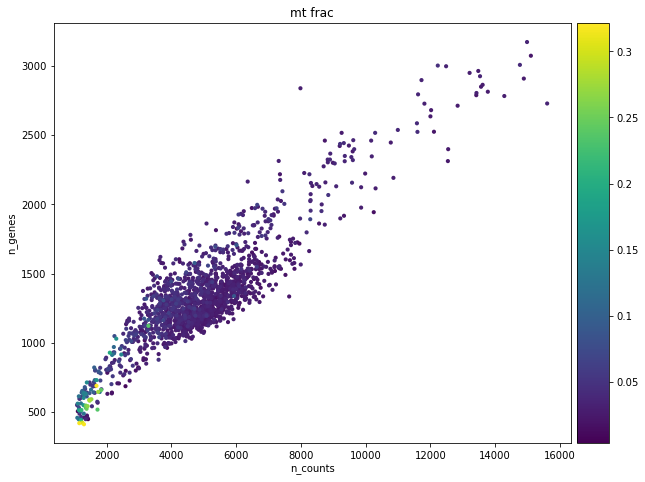

In [30]:
# Look at the effect of thresholding
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='mt_frac')


In [31]:
# Filter cells with high fraction of mitochondrial genes
print('Total number of cells: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))


Total number of cells: 1743
Number of cells after MT filter: 1725


In [32]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 32738
filtered out 22398 genes that are detectedin less than 20 cells


Trying to set attribute `.var` of view, making a copy.


Number of genes after cell filter: 10340


## 1.2 Normalization

In [33]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15, svd_solver='arpack')
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA with n_comps = 15
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished (0:00:08)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


In [34]:
adata_pp.obs['groups'].value_counts()

0    774
1    322
2    273
3    131
4     94
5     78
6     53
Name: groups, dtype: int64

In [35]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

Since the smallest cluster is composed by 53 cells, there is no need to pass sizes as input to computeSumFactors (defalut minimum size = 21)

In [36]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [37]:
#Delete adata_pp
del adata_pp

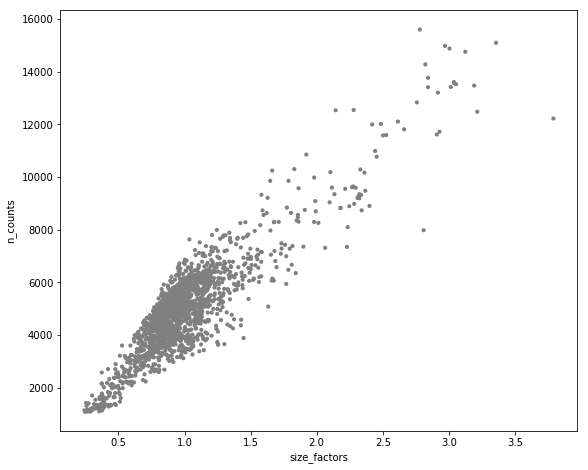

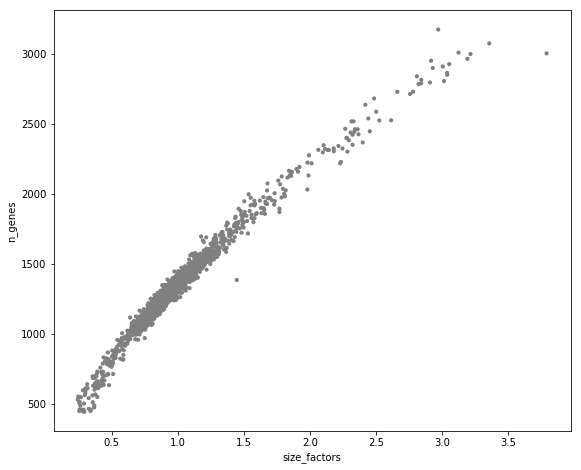

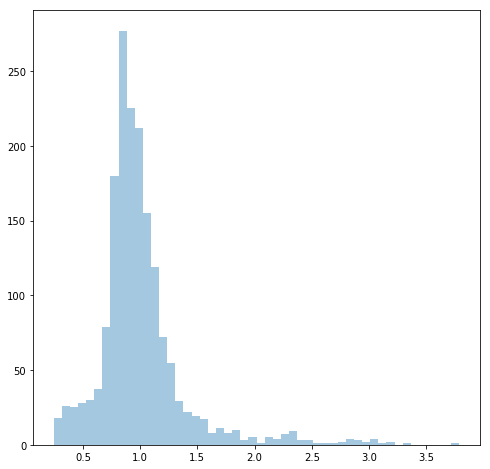

In [38]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [39]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [40]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [41]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

## 1.3 Highly variable genes

In [42]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 3999


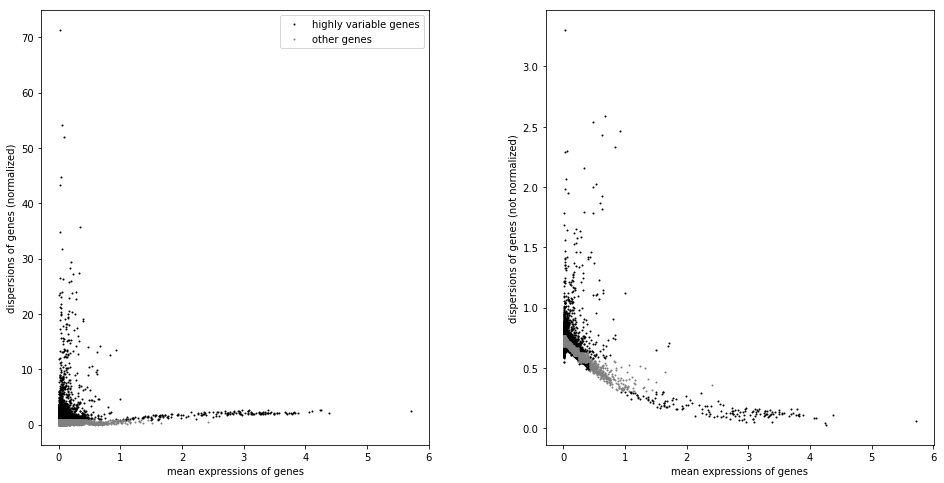

In [43]:
sc.pl.highly_variable_genes(adata)

# 2. Visualization

In [44]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:01)
computing UMAP
    finished (0:00:07)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99835193 0.9931272  0.9913876  0.9723053  0.9688477
     0.9652829  0.95854604 0.9500347  0.92673707 0.91448337 0.89679563
     0.8834742  0.86965215 0.866674  ]
    finished (0:00:00)
drawing single-cell graph using layout 'fa'
    finished (0:00:14)


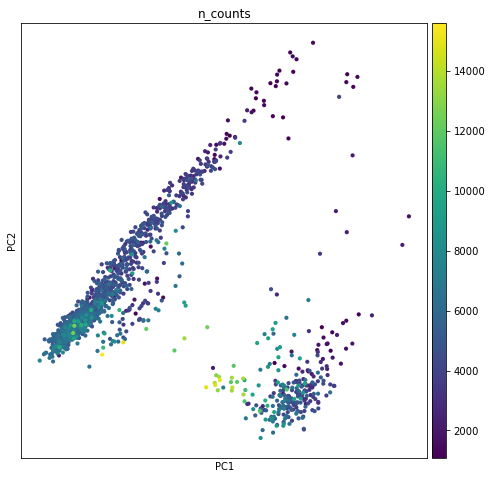

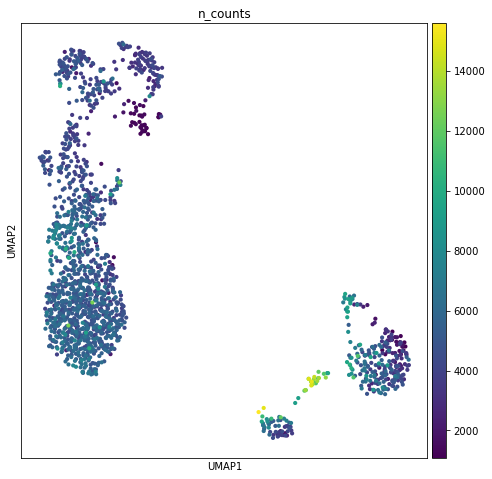

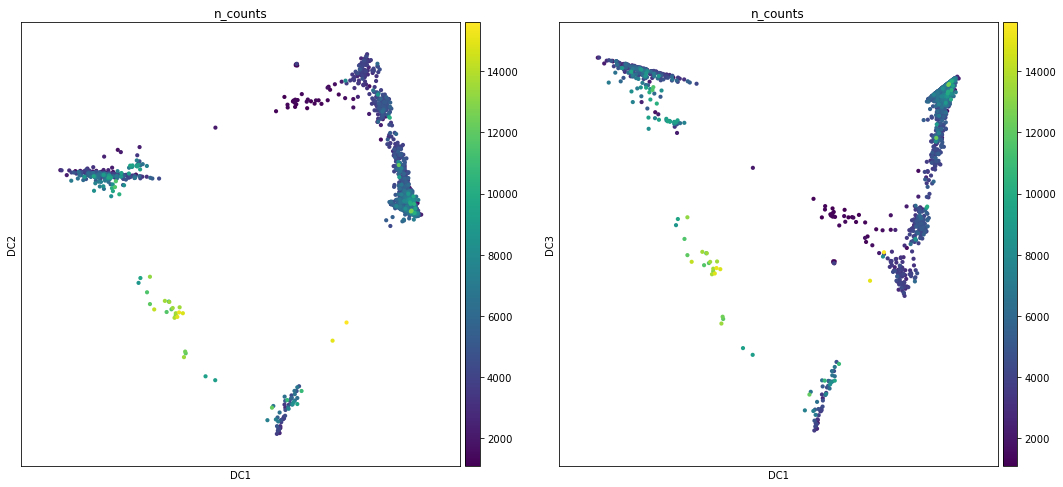

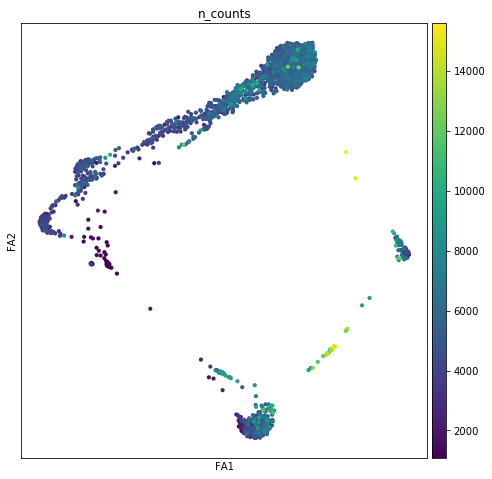

In [45]:
sc.pl.pca_scatter(adata, color='n_counts')
sc.pl.umap(adata, color='n_counts')
sc.pl.diffmap(adata, color='n_counts', components=['1,2','1,3'])
sc.pl.draw_graph(adata, color='n_counts')

In [46]:
adata.write(results_file)

# 3. Clustering

In [47]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, key_added='louvain_r1')
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0.5', random_state=10)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


In [48]:
adata.obs['louvain_r0.5'].value_counts()

0    785
1    342
2    271
3    224
4     79
5     24
Name: louvain_r0.5, dtype: int64

In [49]:
adata.obs['louvain_r1'].value_counts()

0    727
1    286
2    226
3    140
4    130
5    115
6     57
8     22
7     22
Name: louvain_r1, dtype: int64

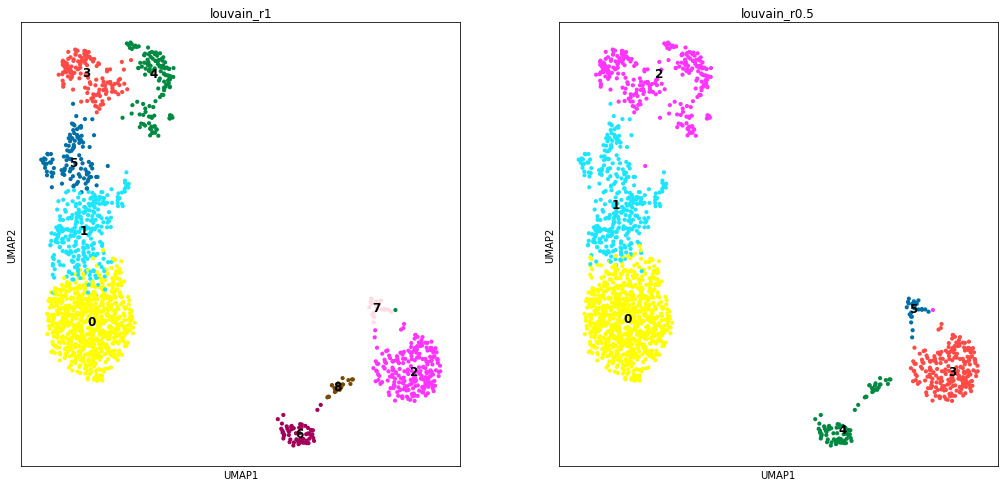

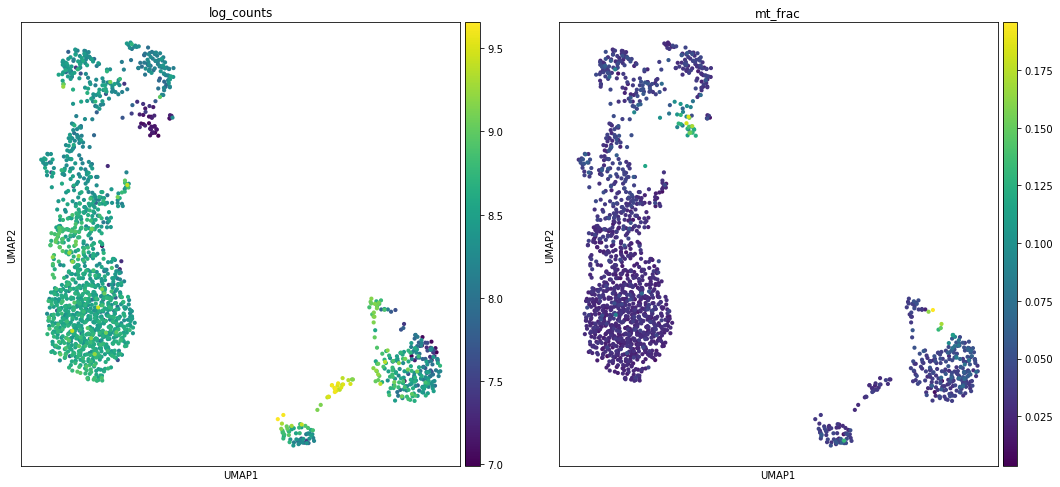

In [50]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['louvain_r1', 'louvain_r0.5'], palette=sc.pl.palettes.default_64, legend_loc='on data', legend_fontsize=12)
sc.pl.umap(adata, color=['log_counts', 'mt_frac'])



# 4. Marker genes and cluster annotation (r 0.5)

## 4.1 Short list of cell types (PanglaoDB)

In [51]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='louvain_r0.5', key_added='rank_genes_r0.5')

ranking genes
    finished (0:00:01)


In [53]:
# Known marker genes taken from PanglaoDB (short list of 12 cell types)
markers_short_df = pd.read_csv('../../../Munich/Immune_markers_short_12.txt', delimiter='\t')
markers_short_df.shape

(975, 14)

In [54]:
markers_short_df.head()

species official.gene.symbol cell.type         nicknames  \
417   Mm Hs                  CD2   B cells               NaN   
418   Mm Hs                  CD5   B cells               NaN   
419   Mm Hs                MS4A1   B cells   Bp35|MS4A2|CD20   
420   Mm Hs                  CR2   B cells         CD21|C3DR   
421   Mm Hs                 CD22   B cells  SIGLEC-2|SIGLEC2   

     ubiquitousness.index             product.description  \
417                 0.040                    CD2 molecule   
418                 0.004                    CD5 molecule   
419                 0.014  membrane spanning 4-domains A1   
420                 0.001       complement C3d receptor 2   
421                 0.003                   CD22 molecule   

               gene.type  canonical.marker germ.layer          organ  \
417  protein-coding gene               NaN   Mesoderm  Immune system   
418  protein-coding gene               1.0   Mesoderm  Immune system   
419  protein-coding gene               1.0   Mesoderm  Immune system   
420  protein-coding gene               1.0   Mesoderm  Immune system   
421  protein-coding gene               1.0   Mesoderm  Immune system   

     sensitivity_human  sensitivity_mouse  specificity_human  \
417           0.000000           0.212355           0.095847   
418           0.000000           0.000000           0.004153   
419           0.483871           0.617761           0.011182   
420           0.048387           0.034749           0.000000   
421           0.096774           0.127413           0.001278   

     specificity_mouse  
417           0.026556  
418           0.004502  
419           0.001566  
420           0.000000  
421           0.000196

Select only genes that are annotated for human:

In [55]:
markers_short_df_hum = markers_short_df[(markers_short_df['species'] == 'Hs') | (markers_short_df['species'] == 'Mm Hs')]
markers_short_df_hum.shape

(892, 14)

In [56]:
cell_types = list(markers_short_df_hum['cell.type'].unique())

In [57]:
markers_dict = {}

In [58]:
for ctype in cell_types:
    df = markers_short_df_hum[markers_short_df_hum['cell.type'] == ctype]
    markers_dict[ctype] = df['official.gene.symbol'].to_list()

In [59]:
cell_annotation = sc.tl.marker_gene_overlap(adata, markers_dict, key='rank_genes_r0.5')
cell_annotation
    

0     1     2     3     4  \
B cells                                       2.0   5.0   1.0   3.0  22.0   
B cells naive                                 1.0   5.0   1.0   1.0  27.0   
Dendritic cells                               1.0   8.0   8.0  18.0  16.0   
Erythroid-like and erythroid precursor cells  0.0   0.0   1.0   3.0   0.0   
Gamma delta T cells                           0.0   1.0  16.0   0.0   0.0   
Monocytes                                     0.0   3.0   4.0  15.0   3.0   
NK cells                                      0.0  11.0  27.0   1.0   0.0   
Plasmacytoid dendritic cells                  1.0   5.0   2.0   2.0   7.0   
Platelets                                     0.0   6.0   7.0   4.0   2.0   
T cells                                       4.0  20.0  16.0   1.0   0.0   
T cytotoxic cells                             0.0   3.0   2.0   0.0   0.0   
T memory cells                                4.0   8.0   3.0   2.0   0.0   

                                                 5  
B cells                                        3.0  
B cells naive                                  1.0  
Dendritic cells                               15.0  
Erythroid-like and erythroid precursor cells   0.0  
Gamma delta T cells                            0.0  
Monocytes                                     12.0  
NK cells                                       2.0  
Plasmacytoid dendritic cells                   0.0  
Platelets                                      2.0  
T cells                                        1.0  
T cytotoxic cells                              0.0  
T memory cells                                 0.0

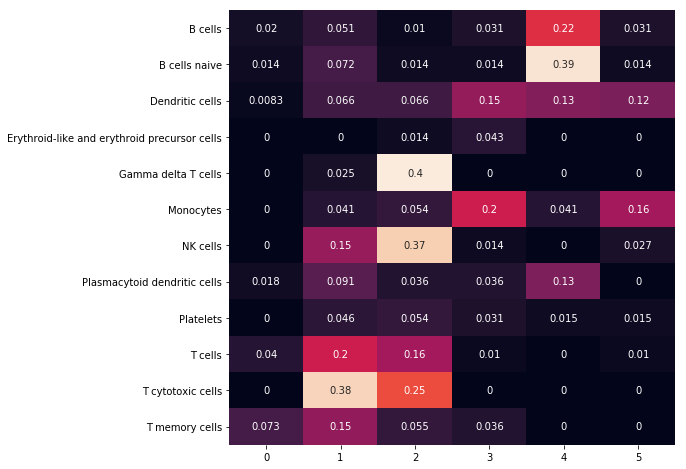

In [60]:
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, markers_dict, key='rank_genes_r0.5', normalize='reference')
sb.heatmap(cell_annotation_norm, cbar=False, annot=True)

In [61]:
#Categories to rename
adata.obs['louvain_r0.5'].cat.categories

Index(['0', '1', '2', '3', '4', '5'], dtype='object')

In [62]:
adata.obs['cell_type0.5short'] = adata.obs['louvain_r0.5']
adata.obs['cell_type0.5short'].cat.categories

Index(['0', '1', '2', '3', '4', '5'], dtype='object')

In [63]:
adata.rename_categories('cell_type0.5short', ['T memory', 'T cytotoxic','Gamma delta T cells', 'Monocytes + Dendritic 1', 'B cells naive', 'Monocytes + Dendritic 2'])

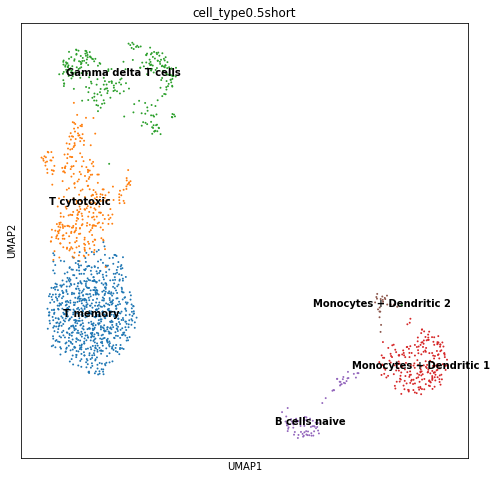

In [64]:
sc.pl.umap(adata, color='cell_type0.5short', size=15, legend_loc='on data')

## 4.2 Long list of cell types
Here we try using the long list of cell types (29) from PanglaoDB, considering all cell types in "immune system" + "blood". We manually checked that all cell types were possible for healthy tissue, so we excluded:
* __Myeloid derived suppressor cells__, description: MDSC are not present at steady state in healthy individuals and appear in cancer and pathological conditions associated with chronic inflammation or stress. 
* __Red pulp macrophages__, description: Present in the red pulp of the spleen. They are necessary for maintaining blood homeostasis by performing phagocytosis upon injured and senescent erythrocytes and blood-borne particulates.

In [66]:
markers_long_df = pd.read_csv('../../../Munich/Immune_markers_long_29.txt', delimiter='\t')
markers_long_df.shape

(1866, 14)

In [67]:
markers_long_df = markers_long_df[markers_long_df['cell.type'] != 'Myeloid-derived suppressor cells']
markers_long_df.shape

(1849, 14)

In [68]:
markers_long_df = markers_long_df[markers_long_df['cell.type'] != 'Red pulp macrophages']
markers_long_df.shape

(1837, 14)

In [69]:
markers_long_df_hum = markers_long_df[(markers_long_df['species'] == 'Hs') | (markers_long_df['species'] == 'Mm Hs')]
markers_long_df_hum.shape

(1685, 14)

In [70]:
cell_types = list(markers_long_df_hum['cell.type'].unique())

In [71]:
markers_dict_long = {}
for ctype in cell_types:
    df = markers_long_df_hum[markers_long_df_hum['cell.type'] == ctype]
    markers_dict_long[ctype] = df['official.gene.symbol'].to_list()

In [72]:
cell_annotation_long = sc.tl.marker_gene_overlap(adata, markers_dict_long, key='rank_genes_r0.5')

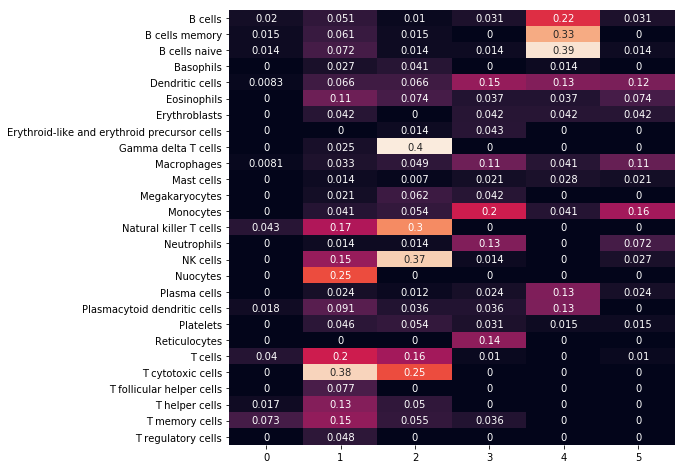

In [73]:
cell_annotation_long_norm = sc.tl.marker_gene_overlap(adata, markers_dict_long, key='rank_genes_r0.5', normalize='reference')
sb.heatmap(cell_annotation_long_norm, cbar=False, annot=True)

Using the long list did NOT actually improve the annotation

# 5. Markers and cluster annotation (r 1)

In [74]:
#Calculate marker genes r1
sc.tl.rank_genes_groups(adata, groupby='louvain_r1', key_added='rank_genes_r1')
cell_annotation_long_r1 = sc.tl.marker_gene_overlap(adata, markers_dict_long, key='rank_genes_r1')

ranking genes
    finished (0:00:01)


## 5.1 Short list of cell types

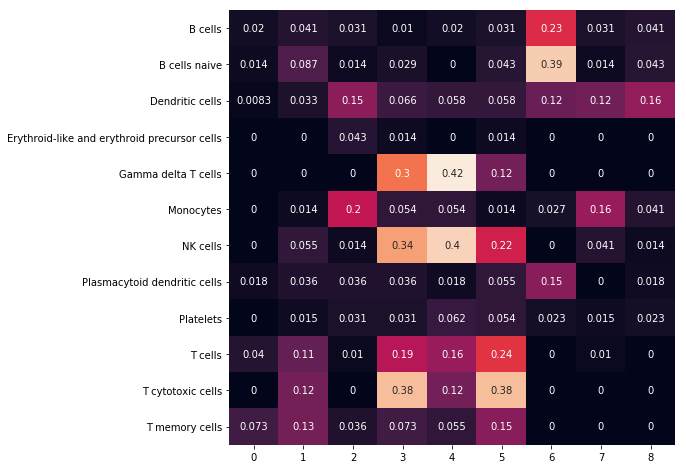

In [75]:
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, markers_dict, key='rank_genes_r1', normalize='reference')
sb.heatmap(cell_annotation_norm, cbar=False, annot=True)

In [77]:
# Categories to rename
adata.obs['cell_type1short'] = adata.obs['louvain_r1']
adata.rename_categories('cell_type1short', ['T memory', 'T cells', 'Monocytes + Dendritic 1', 'T cytotoxic1','Gamma delta T cells+NK', 'T cytotoxic2',  'B cells naive', 'Monocytes + Dendritic 2', 'Dendritic cells'])

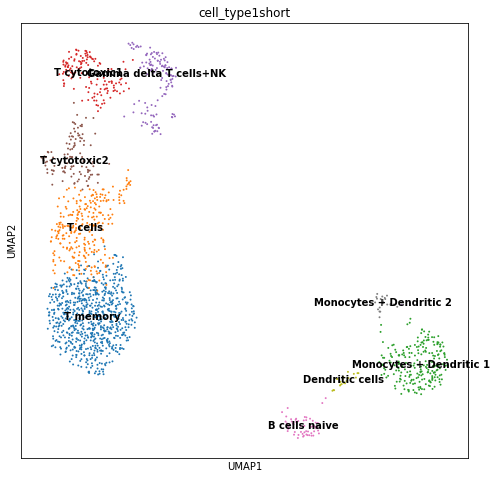

In [78]:
sc.pl.umap(adata, color='cell_type1short', size=15, legend_loc='on data')

## 5.2 Long list of cell types

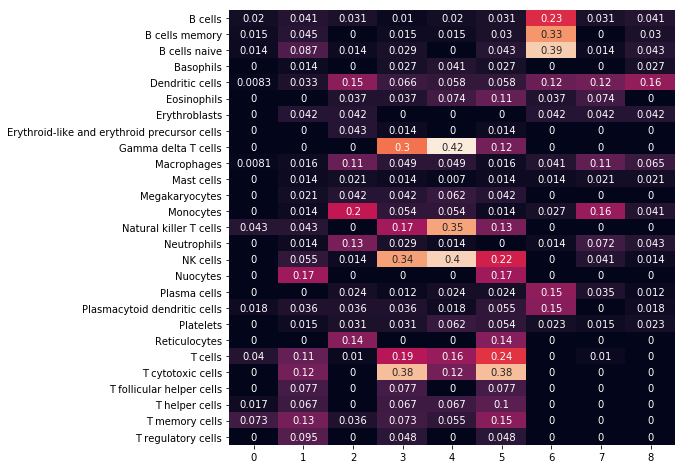

In [79]:
cell_annotation_long_norm_r1 = sc.tl.marker_gene_overlap(adata, markers_dict_long, key='rank_genes_r1', normalize='reference')
sb.heatmap(cell_annotation_long_norm_r1, cbar=False, annot=True)

In [80]:
adata.write(results_file)

# 6. Plot makers of subtypes

In [81]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

## T cells

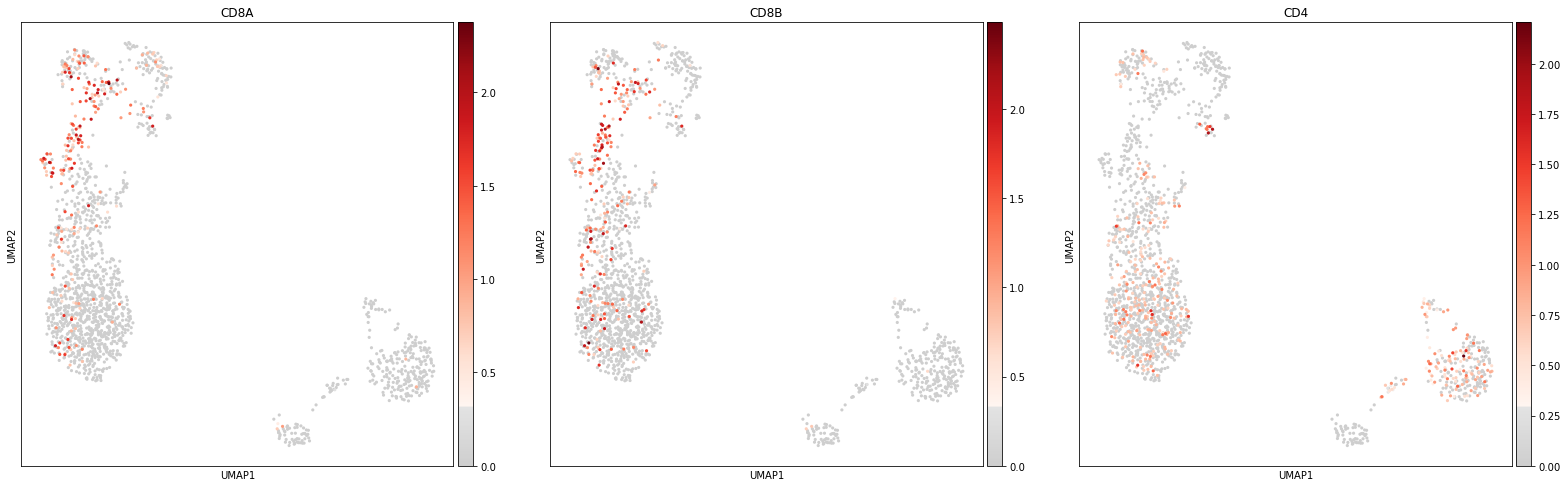

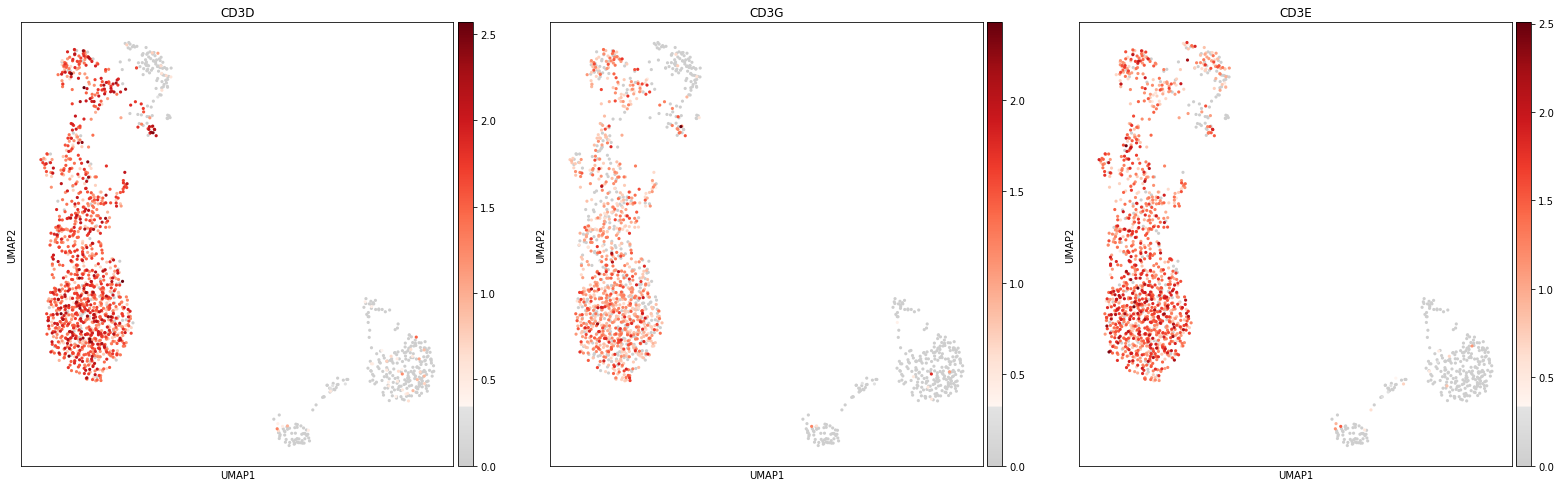

In [83]:
#Canonical markers
sc.pl.umap(adata, color=['CD8A','CD8B', 'CD4'], use_raw=False, color_map=mymap, size = 40)
sc.pl.umap(adata, color=['CD3D', 'CD3G', 'CD3E'], use_raw=False, color_map=mymap, size = 40)

Cluster 3 (louvain r1) is CD8+. Cluster 0 and 1 are CD8 and CD4+. May need to subcluster cluster 5.

### Natural killer T cells

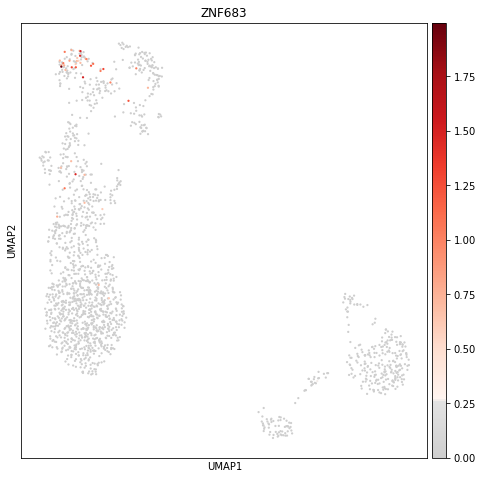

In [86]:
sc.pl.umap(adata, color=['ZNF683'], use_raw=False, color_map=mymap, size = 20)

NKT are present in part of cluster 3 (r1). Marker from[Sinha et al.](https://www.ncbi.nlm.nih.gov/pubmed/29361178)

### T regulatory cells

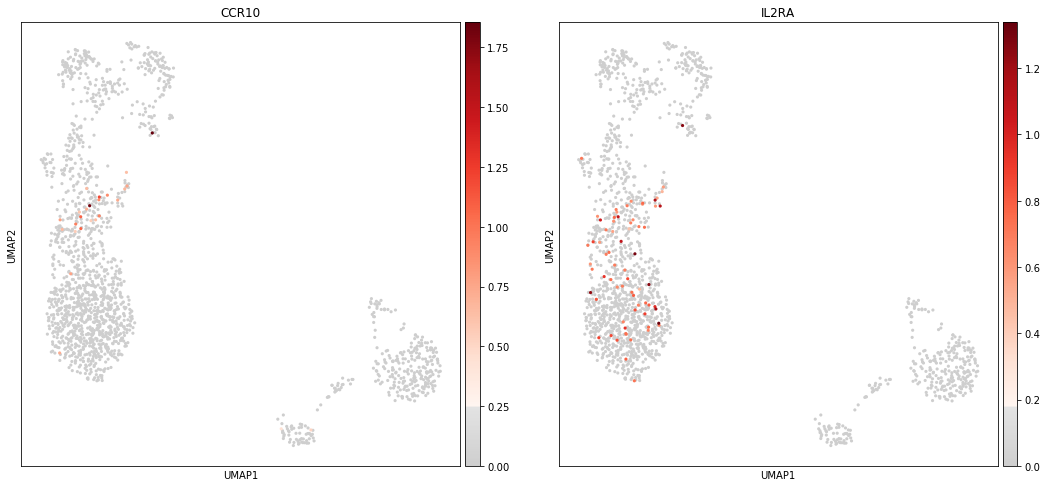

In [90]:
#Canonical markers
sc.pl.umap(adata, color=['CCR10','IL2RA'], use_raw=False, color_map=mymap, size = 40)


Cluster 1 and 0(r1) are also CD4+, so few T reg! [Ballke et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4751285/)

### T memory cells

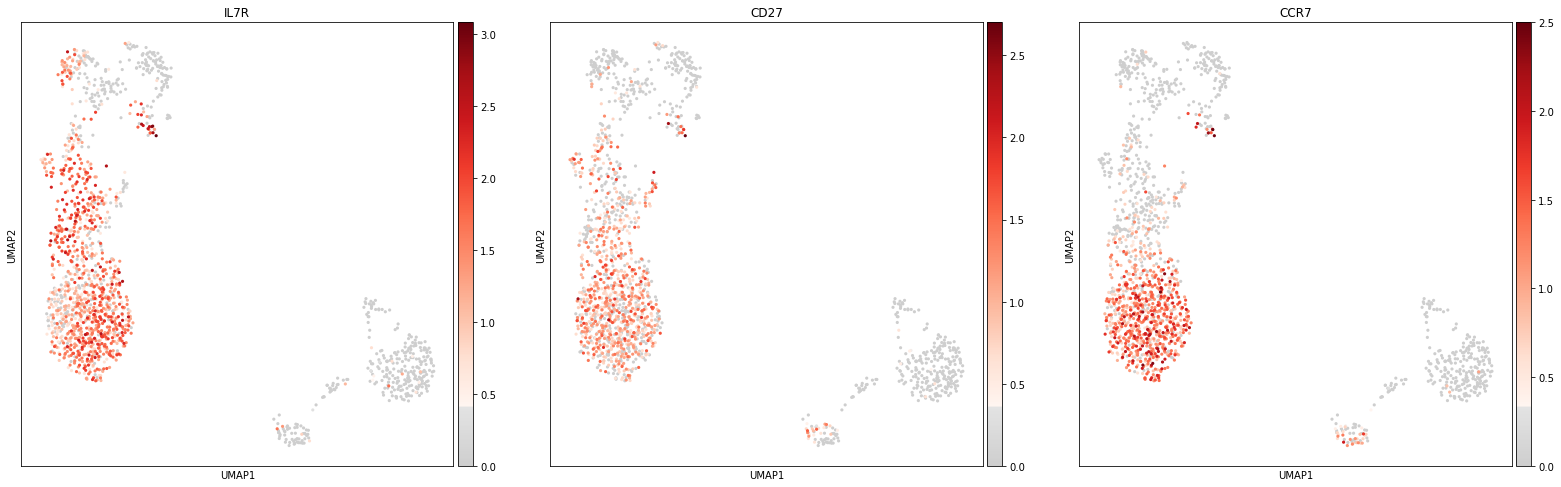

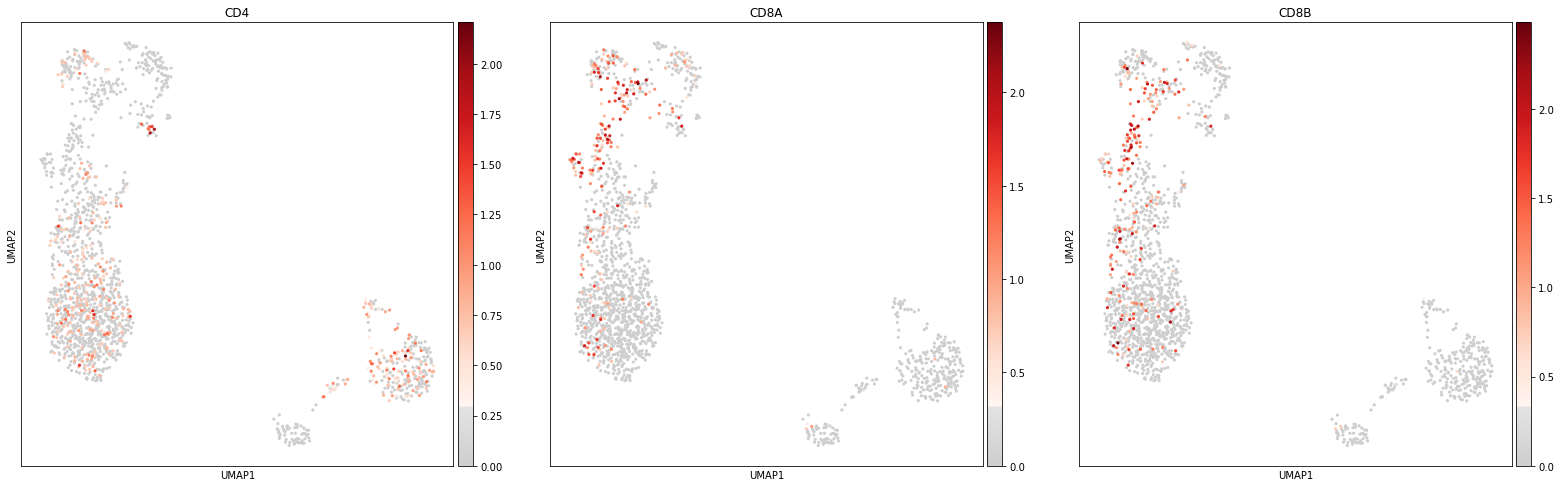

In [116]:
sc.pl.umap(adata, color=['IL7R','CD27', 'CCR7'], use_raw=False, color_map=mymap, size = 40)
sc.pl.umap(adata, color=['CD4', 'CD8A', 'CD8B'], use_raw=False, color_map=mymap, size = 40)


Cluster 0 and 1 are clearly enriched with CD4+ T mem. Part of cluster 5 are CD8+ T memory. (from [CellMarker](http://biocc.hrbmu.edu.cn/CellMarker/search.jsp?species=Human&tissue=Blood&cellname=T%20cell))

### Naive CD8+ T cells

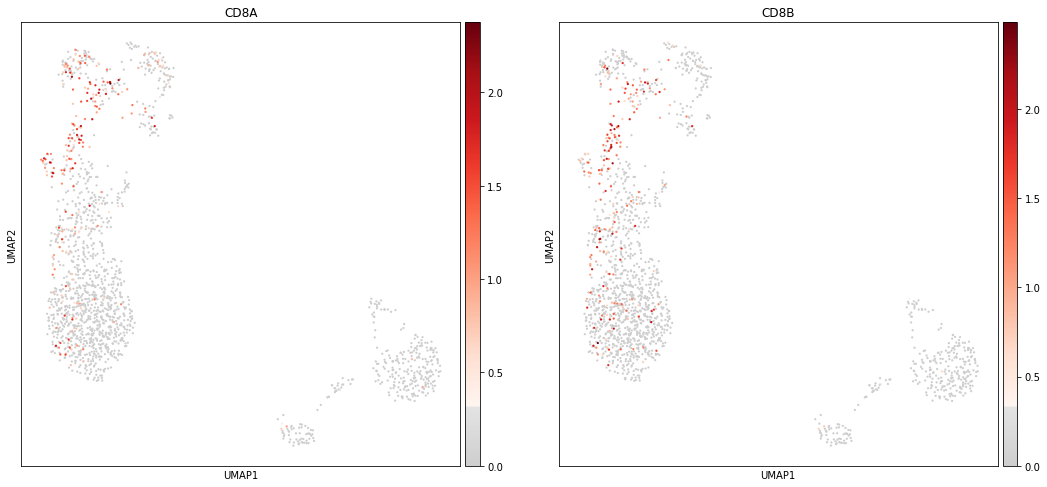

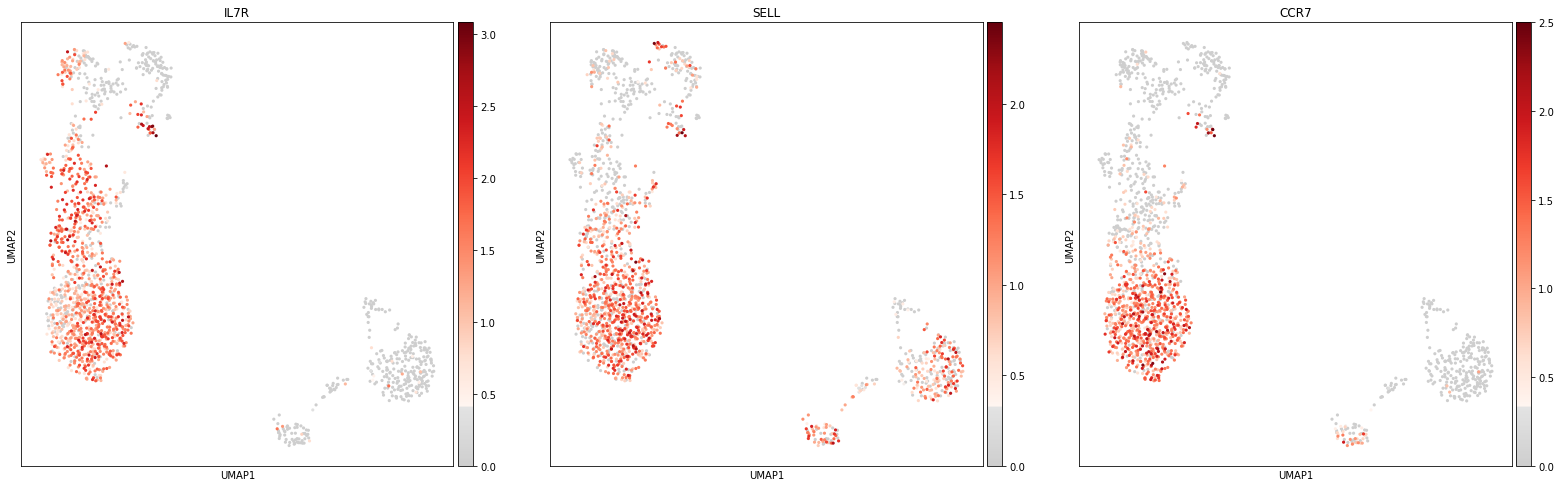

In [112]:
sc.pl.umap(adata, color=['CD8A','CD8B'], use_raw=False, color_map=mymap, size = 20)
sc.pl.umap(adata, color=['IL7R', 'SELL', 'CCR7'], use_raw=False, color_map=mymap, size = 40)

Bottom part of cluster 4 is CD8+ Naive T cells [Samji et al.](https://www.ncbi.nlm.nih.gov/pubmed/28274794)

### Cytotoxic T cells

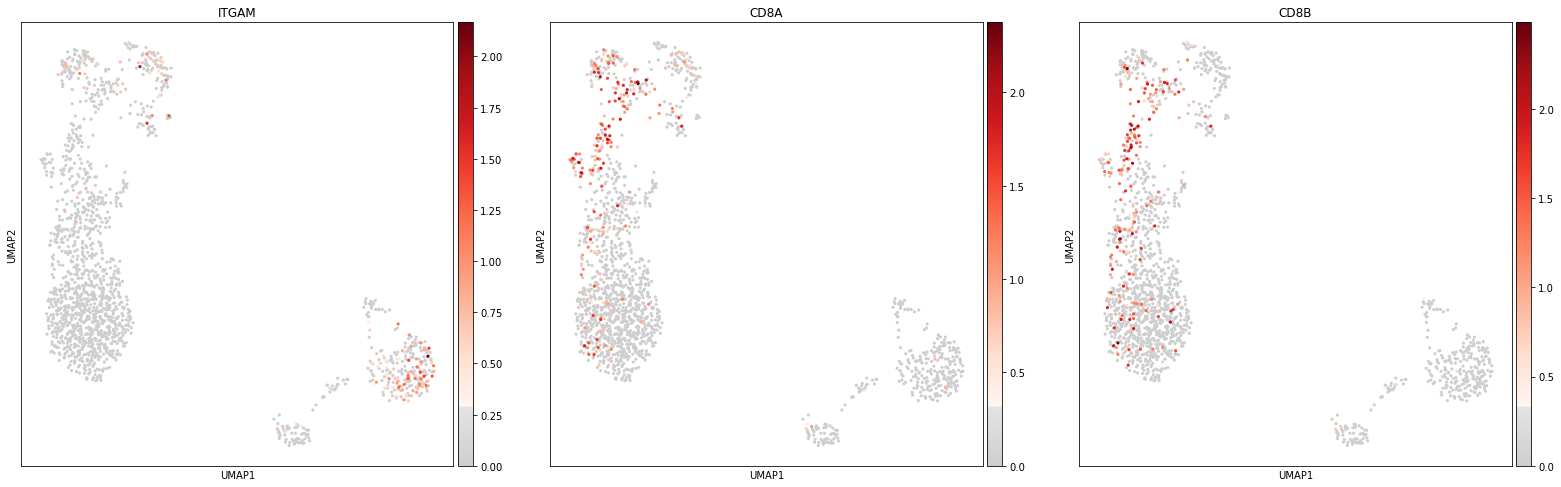

In [93]:
sc.pl.umap(adata, color=['ITGAM','CD8A', 'CD8B'], use_raw=False, color_map=mymap, size = 40)

Cluster 5 is also Cytotoxic T cells ([CellMarker](http://biocc.hrbmu.edu.cn/CellMarker/search.jsp?species=Human&tissue=Blood&cellname=T%20cell))

### Gamma delta T cells

!!!! Look for more markers

## NK cells

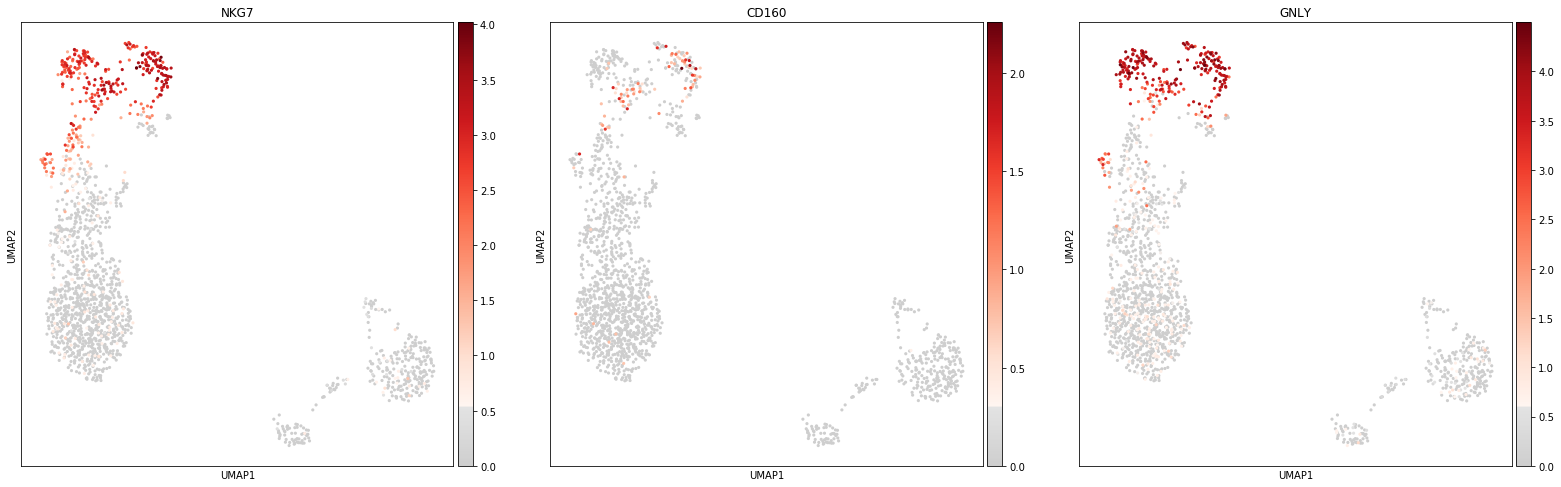

In [94]:
sc.pl.umap(adata, color=['NKG7','CD160', 'GNLY'], use_raw=False, color_map=mymap, size = 40)

Clusters 3, 5 and 6 are enriched with NK cells (Sinha et al)

## Monocytes: CD14+ and CD16+

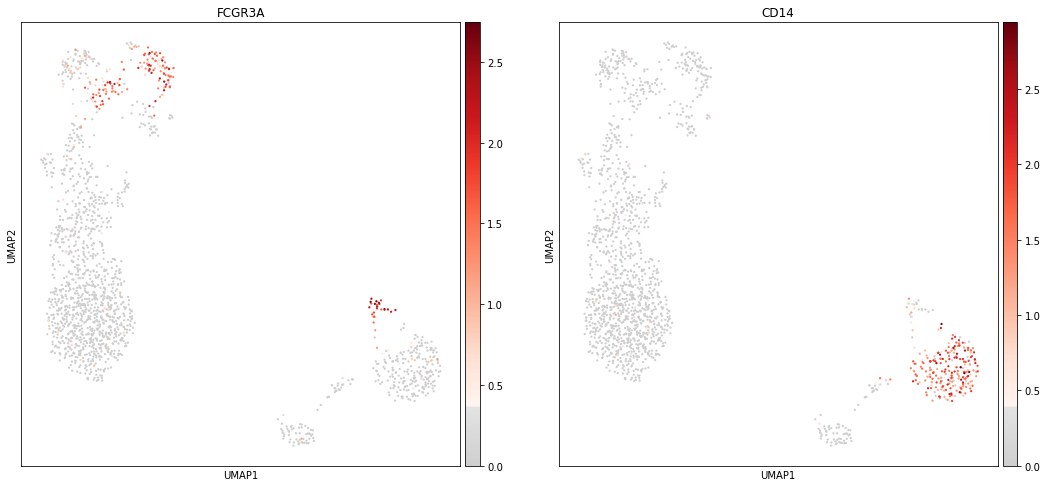

In [95]:
sc.pl.umap(adata, color=['FCGR3A','CD14'], use_raw=False, color_map=mymap, size = 20)

## Monocyte-derived Dendritic cells

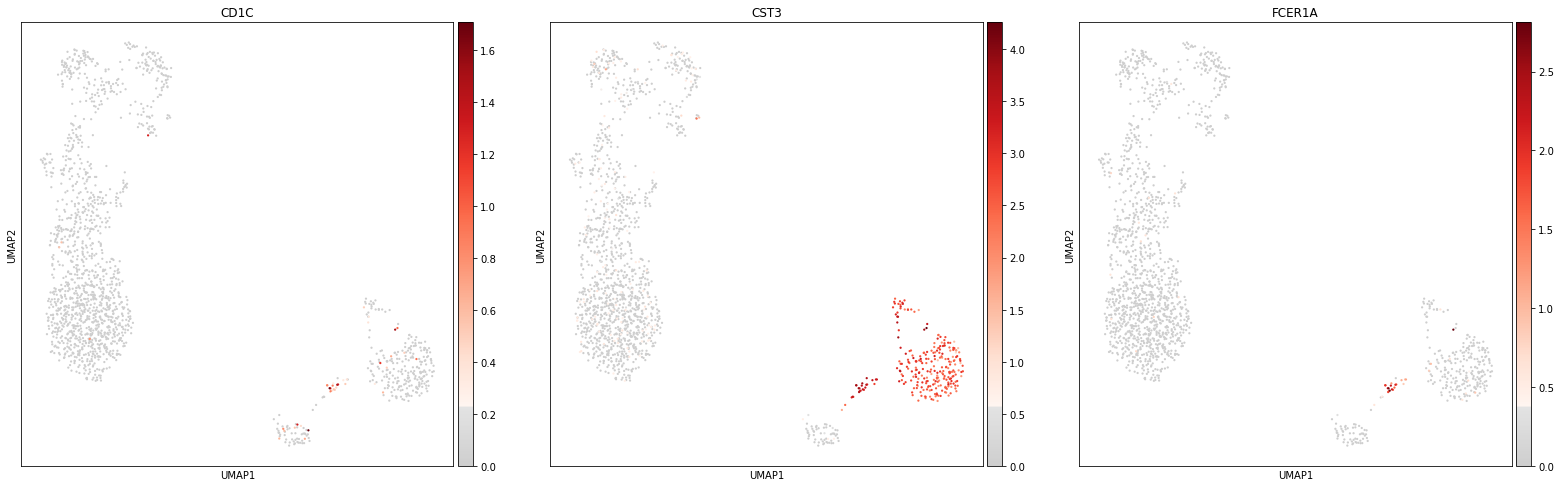

In [96]:
sc.pl.umap(adata, color=['CD1C', 'CST3', 'FCER1A'], use_raw=False, color_map=mymap, size = 20)

Apparently very few cells at the top of cluster 2.  [Sinha et al.](https://www.ncbi.nlm.nih.gov/pubmed/29361178)

## B cells

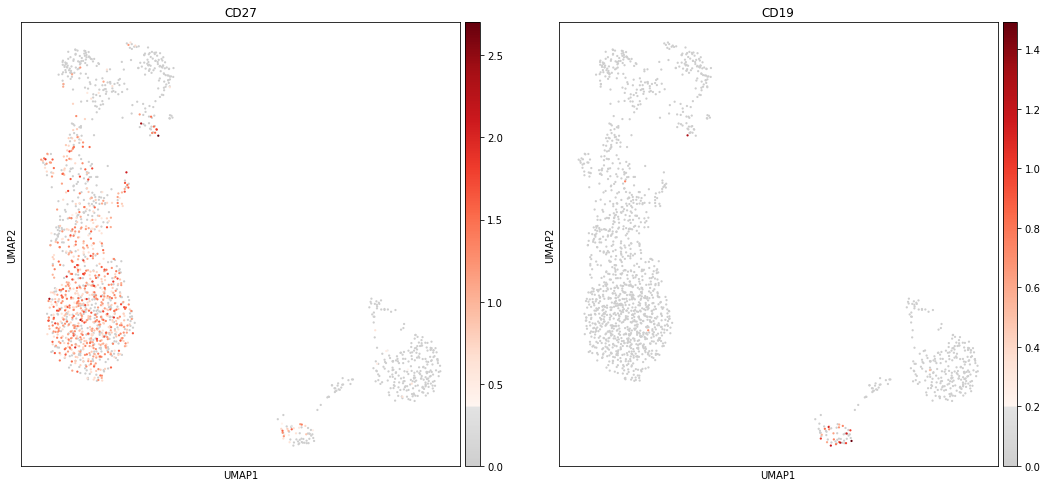

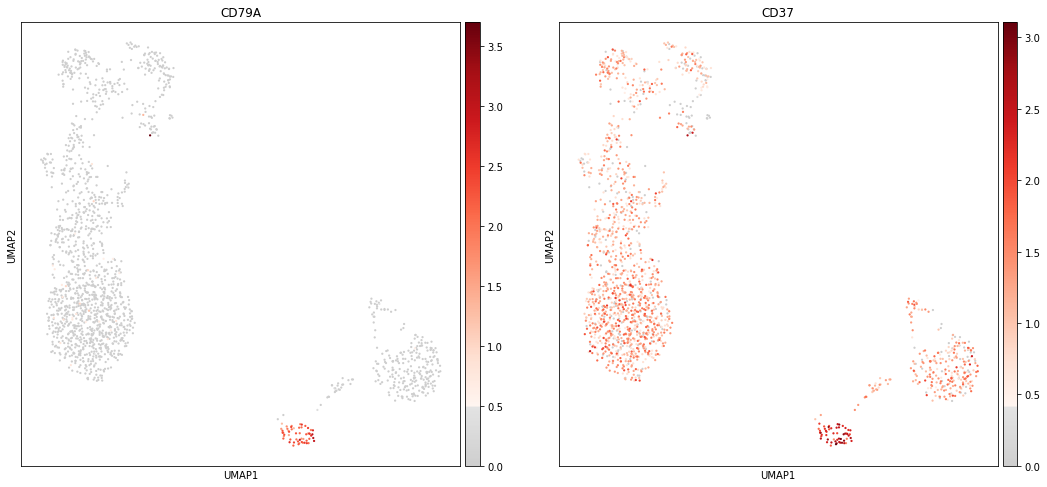

In [97]:
sc.pl.umap(adata, color=['CD27', 'CD19'], use_raw=False, color_map=mymap, size = 20)
sc.pl.umap(adata, color=['CD79A', 'CD37'], use_raw=False, color_map=mymap, size = 20)

First 2 markers are from CellMarker, second 2 from Sinha et al.

## 7. Subclustering

We subcluster starting from louvain_r1 and consider clusters 3, 4 and 5.

In [98]:
#Subcluster cluster3
sc.tl.louvain(adata, restrict_to=('louvain_r1', ['3']), resolution=0.5, key_added='louvain1_clust3_sub')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


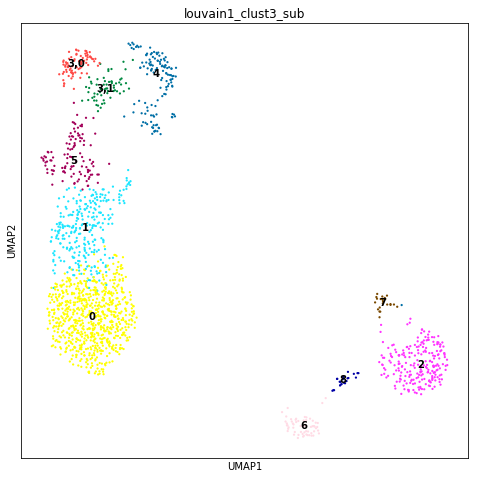

In [99]:
#Show the new clustering
if 'louvain1_clust3_sub_colors' in adata.uns:
    del adata.uns['louvain1_clust3_sub_colors']

sc.pl.umap(adata, color='louvain1_clust3_sub', size = 20, legend_loc = 'on data', palette=sc.pl.palettes.godsnot_64)

In [100]:
#Subcluster cluster 4
sc.tl.louvain(adata, restrict_to=('louvain1_clust3_sub', ['4']), resolution=0.2, key_added='louvain1_clust3_4_sub')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


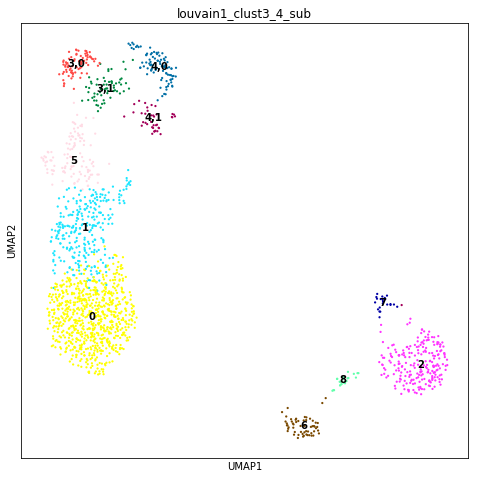

In [101]:
#Show the new clustering
if 'louvain1_clust3_4_sub_colors' in adata.uns:
    del adata.uns['louvain1_clust3_4_sub_colors']

sc.pl.umap(adata, color='louvain1_clust3_4_sub', size = 20, legend_loc = 'on data', palette=sc.pl.palettes.godsnot_64)

In [108]:
#Subcluster cluster 5
sc.tl.louvain(adata, restrict_to=('louvain1_clust3_4_sub', ['5']), resolution=0.5, key_added='louvain1_clust3_4_5_sub')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


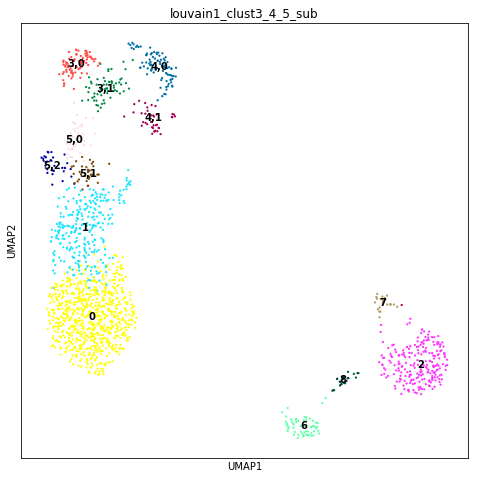

In [109]:
#Show the new clustering
if 'louvain1_clust3_4_5_sub_colors' in adata.uns:
    del adata.uns['louvain1_clust3_4_5_sub_colors']

sc.pl.umap(adata, color='louvain1_clust3_4_5_sub', size = 20, legend_loc = 'on data', palette=sc.pl.palettes.godsnot_64)

In [110]:
#Subcluster cluster 1
sc.tl.louvain(adata, restrict_to=('louvain1_clust3_4_5_sub', ['1']), resolution=0.5, key_added='louvain1_clust3_4_5_1_sub')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


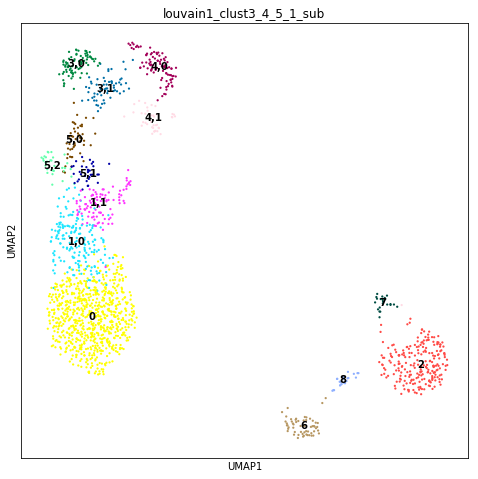

In [111]:
#Show the new clustering
if 'louvain1_clust3_4_5_1_sub_colors' in adata.uns:
    del adata.uns['louvain1_clust3_4_5_1_sub_colors']

sc.pl.umap(adata, color='louvain1_clust3_4_5_1_sub', size = 20, legend_loc = 'on data', palette=sc.pl.palettes.godsnot_64)

# 8. Final cell-type annotation

In [118]:
# Categories to rename
adata.obs['final_annotation'] = adata.obs['louvain1_clust3_4_5_1_sub']
adata.obs['final_annotation'].cat.categories

Index(['0', '1,0', '1,1', '2', '3,0', '3,1', '4,0', '4,1', '5,0', '5,1', '5,2',
       '6', '7', '8'],
      dtype='object')

In [119]:
adata.rename_categories('final_annotation', ['CD4+ T memory, 1', 'CD4+ T memory, 2', 'T regulatory cells', 'CD14+ Monocytes', 'NKT + NK cells', 'NK cells', 'T cytotoxic + NK cells', 'CD8+ Naive T cells', 'CD8+ T memory,1', 'CD4+ T memory, 3', 'CD8+ T memory,2', 'B cells', 'CD16+ Monocytes', 'Monocytes-derived dendritic cells'])

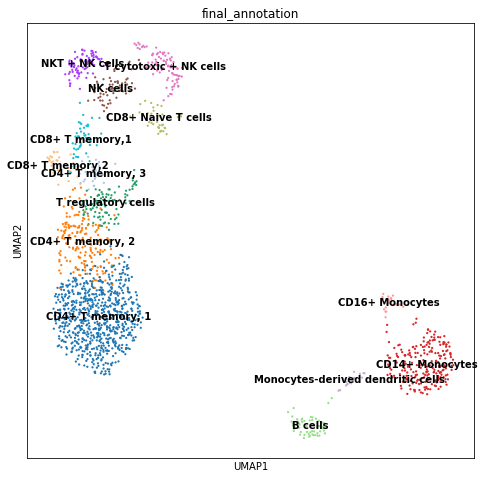

In [121]:
sc.pl.umap(adata, color='final_annotation', size=20, legend_loc='on data')

In [122]:
tmp = adata.obs['final_annotation']
tmp = ['CD8+ T memory' if item.startswith('CD8+ T memory') else item for item in tmp]
tmp = ['CD4+ T memory' if item.startswith('CD4+ T memory') else item for item in tmp]
adata.obs['final_annotation'] = tmp

... storing 'final_annotation' as categorical


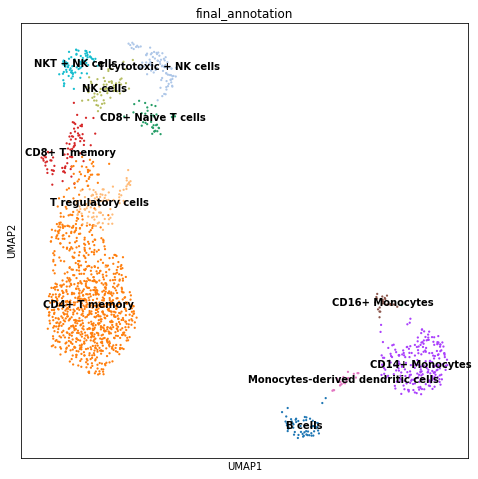

In [123]:
sc.pl.umap(adata, color='final_annotation', size=20, legend_loc='on data')

In [124]:
# save final result
adata.write(results_file)